In [146]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
import shap
import joblib
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

import xgboost as xgb
import os
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers, callbacks, optimizers, backend as K
from tensorflow.keras.layers import Input, Dense, Dropout, BatchNormalization, Add, Concatenate
from tensorflow.keras.models import Model, load_model

import keras_tuner as kt
DATA_DIR = 'data'
MODEL_DIR = 'models'

# Display settings
# pd.set_option('display.max_columns', None)





def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    mask = y_true != 0
    return np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask]))



def get_unique_path(base_path):
    if not os.path.exists(base_path):
        return base_path
    name, ext = os.path.splitext(base_path)
    version = 2
    new_path = f"{name}_V{version}{ext}"
    while os.path.exists(new_path):
        version += 1
        new_path = f"{name}_V{version}{ext}"
    return new_path

def saveModel(model, fileName):
    base_path = os.path.join(MODEL_DIR, fileName)
    path = get_unique_path(base_path)

    if 'nn' in fileName:
        model.save(path)
    else:
        joblib.dump(model, path)
        

def loadModel(modelName):
    path = os.path.join(MODEL_DIR, modelName)
    if 'nn' in modelName:
        return load_model(path)
    else:
        return joblib.load(path)
    



def read_file(csvFileName):
    return pd.read_csv(DATA_DIR+'/'+csvFileName)


In [ ]:
# DATA CLEANING 

def cleanColumns(data):
       # Drop 'Unnamed: 0' column
    #remove brackets
    if "Unnamed: 0" in data.columns:
        data = data.drop(["Unnamed: 0"], axis="columns")
    columns = data.columns
    data.columns =  [re.sub(r'\s*\([^)]*\)', '', col).strip() for col in columns]
    return data

def applyConstraints(data):
    return data[(data['Tank Width'] > 0) & 
                (data['Tank Length'] > 0) & 
                (data['Tank Height'] > 0) & 
                (data['Vapour Height'] >= 0) &
                (data['Vapour Temperature'] > 0) &
                (data['Liquid Temperature'] > 0)]

def standardizeStatus(data):
    data["Status"] = data["Status"].str.lower().str.replace(' ', '')
    data['Status'] = data['Status'].apply(lambda x: 'superheated' if 'h' in x else ('subcooled' if 'c' in x else x))
    return data["Status"]

def remove_outliers_iqr(df, numeric_cols):
    cleaned_df = df.copy()
    total_outliers = 0

    for col in numeric_cols:
        Q1 = cleaned_df[col].quantile(0.25)
        Q3 = cleaned_df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        outliers = cleaned_df[(cleaned_df[col] < lower_bound) | (cleaned_df[col] > upper_bound)]
        cleaned_df = cleaned_df[(cleaned_df[col] >= lower_bound) & (cleaned_df[col] <= upper_bound)]

        outlier_count = len(outliers)
        if outlier_count > 0:
            print(f"\nColumn: {col}")
            print(f"  IQR range: [{lower_bound:.2f}, {upper_bound:.2f}]")
            print(f"  Count of outliers: {outlier_count}")
            print(f"  Sample outlier values:\n{outliers[col].head(5).to_string(index=False)}")

        total_outliers += outlier_count

    print(f"\nTotal outliers removed: {total_outliers}")
    return cleaned_df

def clean_data(data):
    # Initial row count
    initial_rows = len(data)
    print(f"Initial rows: {initial_rows}")

    # Cleanup columns
    data = cleanColumns(data)

    # Drop rows with missing values
    before_na = len(data)
    data = data.dropna(axis=0)
    after_na = len(data)
    print(f"Rows removed due to NA: {before_na - after_na}")

    # Logical constraints
    before_constraints = len(data)
    data = applyConstraints(data)
    after_constraints = len(data)
    print(f"Rows removed due to logical constraints: {before_constraints - after_constraints}")

    #Duplicates
    before_duplicates = len(data)
    data = data.drop_duplicates()
    after_duplicates = len(data)
    print(f"Rows removed as duplicates: {before_duplicates - after_duplicates}")

    # Standardize 'Status' column
    data["Status"] = standardizeStatus(data)


    numeric_cols = data.select_dtypes(include=['float64', 'int64']).columns
    before_outliers = len(data)
    data = remove_outliers_iqr(data, numeric_cols)
    after_outliers = len(data)
    print(f"Rows removed as outliers: {before_outliers - after_outliers}")

    # Final row count
    final_rows = len(data)
    print(f"Final rows: {final_rows}")
    print(f"Total rows removed after cleaning up: {initial_rows - final_rows}")
    return data





In [ ]:
def feature_engineer(data):
    
    data["Liquid Boiling Temperature"] = data["Liquid Boiling Temperature"] +273.15
    data["Liquid Critical Temperature"] = data["Liquid Critical Temperature"] +273.15
    data["Tank Volume"] = data["Tank Width"] * data["Tank Length"] * data["Tank Height"]  
    data["HeightRatio"]= data["Vapour Height"] / data["Tank Height"] 
    data["Superheat Margin"] = data["Liquid Temperature"] - data["Liquid Boiling Temperature"]
    # Total Energy (approximate thermal energy in the tank)
    data["Liquid Volume"] = data["Liquid Ratio"] * data["Tank Volume"]
    data["Total Energy"] = data["Liquid Volume"] * data["Superheat Margin"]

    # (BLEVE assumed at tank center top)
    data["Sensor Distance to BLEVE"] = (
        data["Sensor Position x"]**2 +
        data["Sensor Position y"]**2 +
        (data["Sensor Position z"] - data["BLEVE Height"])**2
    ) ** 0.5
    return data


def preprocess(data,train=True,feature_eng = True):

    if train:
        data = clean_data(data)
    data = pd.get_dummies(data, columns=["Sensor Position Side"], prefix="Side")
    data = pd.get_dummies(data, columns=["Status"], prefix="Status")
    print(data.head(1))
    if feature_eng:
        data = feature_engineer(data)
    y =  None
    if (train):
        y= data[ "Target Pressure"] 
        data = data.drop(["Target Pressure"], axis="columns")
    
    # StandardScaler for inputs
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(data)

    #split data
    
    X_train, X_val, y_train, y_val = train_test_split(
        X_scaled, y, test_size=0.2, random_state=42
    )
    print("Training Set Size:", X_train.shape)
    print("Validation Set Size:", X_val.shape)
    return  X_train, X_val, y_train, y_val


In [110]:
### LOAD DATA HERE
trainData = read_file('train.csv')
trainData = preprocess(trainData,True,False)
X_train, X_val, y_train, y_val= trainData


Initial rows: 10050
Rows removed due to NA: 110
Rows removed due to logical constraints: 0
Rows removed as duplicates: 50

Column: Tank Failure Pressure
  IQR range: [-16.27, 62.29]
  Count of outliers: 48
  Sample outlier values:
1446.628788
3404.750305
1722.348566
4095.753928
2379.656661

Column: Vapour Height
  IQR range: [-0.79, 2.41]
  Count of outliers: 38
  Sample outlier values:
2.60
2.59
2.59
2.61
2.60

Column: Sensor Position y
  IQR range: [-9.47, 15.53]
  Count of outliers: 33
  Sample outlier values:
16.2
16.2
16.2
16.2
16.2

Column: Sensor Position z
  IQR range: [-9.90, 14.90]
  Count of outliers: 33
  Sample outlier values:
15.7
15.7
15.7
15.7
15.7

Column: Target Pressure
  IQR range: [-0.36, 0.88]
  Count of outliers: 882
  Sample outlier values:
1.093819
1.091484
1.036741
1.163416
1.136221

Total outliers removed: 1034
Rows removed as outliers: 1034
Final rows: 8856
Total rows removed after cleaning up: 1194
Highly correlated features to drop: ['Liquid Boiling Temper

In [ ]:
#SVM and XgbBoost
def plot_grid_search_results(grid_search, metric='mean_test_score', top_n=20):
    results = pd.DataFrame(grid_search.cv_results_)
    results = results.sort_values(by=metric, ascending=False).head(top_n)

    # Drop time-related or redundant columns
    params_df = results.filter(like='param_')
    scores = results[metric]

    # Combine params and score
    data = params_df.copy()
    data['Score'] = scores.values

    # Normalize parameter values for better comparison (optional)
    for col in data.columns[:-1]:
        try:
            data[col] = data[col].astype(float)
        except:
            pass  # leave categorical

    # Melt for seaborn plotting
    melted = data.melt(id_vars='Score', var_name='Parameter', value_name='Value')

    # Plot
    plt.figure(figsize=(12, 6))
    sns.stripplot(data=melted, x='Parameter', y='Value', hue='Score', palette='viridis', size=10, jitter=True)
    plt.title(f"Top {top_n} GridSearchCV Results by Parameters and {metric}")
    plt.xticks(rotation=45)
    plt.legend(title='Score', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

def summarize_results(model,name):
    y_pred = model.predict(X_val)

    # Compute metrics
    mse = mean_squared_error(y_val, y_pred)
    r2 = r2_score(y_val, y_pred)

    print(f"MSE: {mse:.4f}")
    print(f"R²: {r2:.4f}")
    summary = {
        'Model': name,
        'MSE': mse,
        'R2': r2,
        'Best Params': str(model.getparams())
    }
    return pd.DataFrame([summary])

def train_xgboost():
    param_grid = {
        'n_estimators': [100, 200],
        'max_depth': [3, 6],
        'learning_rate': [0.01, 0.1],
        'subsample': [0.7, 0.9],
        # 'colsample_bytree': [0.7, 0.9],
        # 'colsample_bylevel': [0.7, 0.9],  # NEW
        # 'gamma': [0, 0.1],
        # 'min_child_weight': [1, 5],
        # 'reg_lambda': [1, 10],  # NEW (was: lambda)
        # 'reg_alpha': [0, 1]     # NEW (was: alpha)
    }


    model = xgb.XGBRegressor(objective="reg:squarederror", random_state=42)
    grid_search = GridSearchCV(model, param_grid=param_grid, cv=3, scoring='neg_mean_squared_error', verbose=1, n_jobs=-1)
    grid_search.fit(X_train, y_train)
    plot_grid_search_results(grid_search, metric='mean_test_score', top_n=30)
    best_model = grid_search.best_estimator_
    return best_model


def train_svr():
    param_grid = {
        'svr__C': [0.01,0.1,1, 10, 100],
        'svr__epsilon': [0.01, 0.1,0.5],
        'svr__kernel': ['rbf','poly']
    }

    pipeline = make_pipeline(SVR())
    grid_search = GridSearchCV(pipeline, param_grid=param_grid, cv=3, scoring='neg_mean_squared_error', verbose=1, n_jobs=-1)
    grid_search.fit(X_train, y_train)
    
    best_model = grid_search.best_estimator_
    return best_model







In [111]:
# Neural network
def mish(x):
    return x * tf.math.tanh(tf.math.softplus(x))


def build_nn():
    model = models.Sequential([
        layers.Dense(256, activation='mish', input_shape=(X_train.shape[1],),
                    kernel_regularizer=regularizers.l2(1e-5)),
        layers.Dropout(0.1),
        layers.Dense(256, activation='mish', kernel_regularizer=regularizers.l2(1e-5)),
        layers.Dropout(0.1),
        layers.Dense(256, activation='mish', kernel_regularizer=regularizers.l2(1e-5)),
        layers.Dropout(0.1),
        layers.Dense(1, activation='softplus')
    ])

    optimizer = optimizers.SGD(learning_rate=0.1, momentum=0.9)
    model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])

    # optimizer = optimizers.Adam(learning_rate=0.001)
    # model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])

    # Callbacks
    
    return model




def plot_nn(history):
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Training & Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Plot Training & Validation MAE
    plt.subplot(1, 2, 2)
    plt.plot(history.history['mae'], label='Training MAE')
    plt.plot(history.history['val_mae'], label='Validation MAE')
    plt.title('Training & Validation MAE')
    plt.xlabel('Epochs')
    plt.ylabel('Mean Absolute Error')
    plt.legend()

    # Show the plots
    plt.tight_layout()
    plt.show()


def train_nn(model):
    early_stop = callbacks.EarlyStopping(
        monitor='val_loss', patience=100, restore_best_weights=True
    )
    history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=500,
    batch_size=32,
    callbacks=[early_stop],
    verbose=2)
    plot_nn(history)
    return history









In [ ]:
#TRAINING
svr_model = train_svr()
summarize_results(svr_model)

In [ ]:
xgb_model = train_xgboost()




ValueError: File format not supported: filepath=xgb.pkl. Keras 3 only supports V3 `.keras` files and legacy H5 format files (`.h5` extension). Note that the legacy SavedModel format is not supported by `load_model()` in Keras 3. In order to reload a TensorFlow SavedModel as an inference-only layer in Keras 3, use `keras.layers.TFSMLayer(xgb.pkl, call_endpoint='serving_default')` (note that your `call_endpoint` might have a different name).

In [100]:
nn_model = build_nn()

/home/21827840/uni/ML/assignment/tf/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/500


222/222 - 3s - 11ms/step - loss: 0.0197 - mae: 0.0764 - val_loss: 0.0126 - val_mae: 0.0575
Epoch 2/500
222/222 - 1s - 3ms/step - loss: 0.0119 - mae: 0.0553 - val_loss: 0.0116 - val_mae: 0.0537
Epoch 3/500
222/222 - 0s - 1ms/step - loss: 0.0112 - mae: 0.0519 - val_loss: 0.0107 - val_mae: 0.0493
Epoch 4/500
222/222 - 0s - 1ms/step - loss: 0.0109 - mae: 0.0506 - val_loss: 0.0107 - val_mae: 0.0493
Epoch 5/500
222/222 - 0s - 1ms/step - loss: 0.0103 - mae: 0.0484 - val_loss: 0.0103 - val_mae: 0.0480
Epoch 6/500
222/222 - 0s - 2ms/step - loss: 0.0100 - mae: 0.0469 - val_loss: 0.0100 - val_mae: 0.0460
Epoch 7/500
222/222 - 0s - 1ms/step - loss: 0.0098 - mae: 0.0458 - val_loss: 0.0099 - val_mae: 0.0460
Epoch 8/500
222/222 - 0s - 1ms/step - loss: 0.0097 - mae: 0.0455 - val_loss: 0.0095 - val_mae: 0.0437
Epoch 9/500
222/222 - 0s - 2ms/step - loss: 0.0095 - mae: 0.0448 - val_loss: 0.0099 - val_mae: 0.0448
Epoch 10/500
222/222 - 0s - 2ms/step - loss: 0.0095 - mae: 0.0446 - val_loss: 0.0096 - val_ma

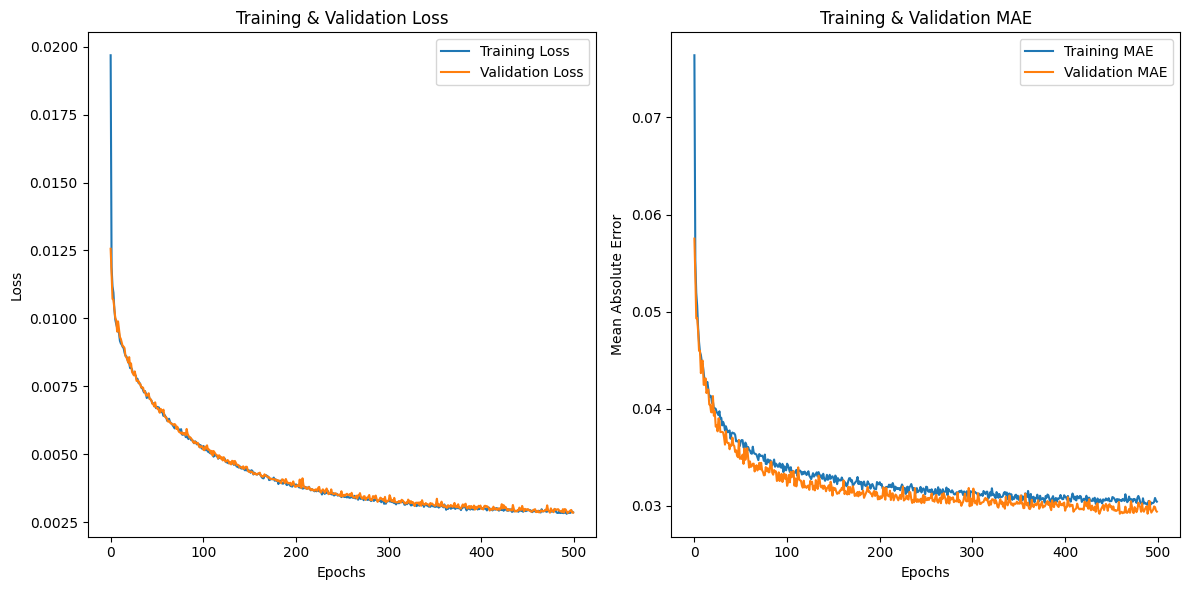

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 0.0028 - mae: 0.0293
Validation Loss: 0.0028284965083003044
Validation MAE: 0.029310442507267


In [101]:
history = train_nn(nn_model)

val_loss, val_mae = nn_model.evaluate(X_val, y_val, batch_size=512, verbose=1)

# Print the results
print(f"Validation Loss: {val_loss}")
print(f"Validation MAE: {val_mae}")

ValueError: File not found: filepath=nn.keras. Please ensure the file is an accessible `.keras` zip file.

In [ ]:
model.save('best.keras')

NameError: name 'model' is not defined

In [94]:
# Assuming you have X_test and y_test prepared
# 1. Evaluate the model on the test set
test_data = read_file('test.csv')
test_data = preprocess(test_data,False,False)
y_test = pd.read_csv("sample_prediction.csv")
predData = y_test["Target Pressure (bar)"]
test_scaled,_ = preprocess(test_data,True)
test_loss, test_mae = xgb_model.evaluate(test_scaled, predData)
print(f"Test Loss: {test_loss}")
print(f"Test MAE: {test_mae}")


y_pred = model.predict(test_scaled).flatten()  # Ensure it's a 1D array

# 2. Get the true target values
y_true = y_test["Target Pressure (bar)"].values



# 3. Calculate MAPE (excluding zero targets to avoid division by zero)


# 4. Compute and print MAPE
mape = mean_absolute_percentage_error(y_true, y_pred)
print(f"MAPE: {mape/10}")


# Assuming the ID column in the test data is named 'ID'
# 1. Create a DataFrame with the predictions and IDs
output_df = pd.DataFrame({
    'ID': y_test['ID'],  # Assuming 'ID' is in the test_data
    'Target Pressure (bar)': y_pred  # The predicted values
})

# 2. Save the DataFrame to a CSV file
output_df.to_csv('predictions_output.csv', index=False)
print("Predictions have been saved to 'predictions_output.csv'.")


   Unnamed: 0  Tank Failure Pressure (bar)  Liquid Ratio  Tank Width (m)  \
0           0                         37.9      0.412227             0.8   

   Tank Length (m)  Tank Height (m)  BLEVE Height (m)  Vapour Height (m)  \
0              6.6              0.4               0.8                0.2   

   Vapour Temperature (K)  Liquid Temperature (K)  \
0                   317.6                   337.5   

   Obstacle Distance to BLEVE (m)  Obstacle Width (m)  Obstacle Height (m)  \
0                               7                   9                   12   

   Obstacle Thickness (m)  Obstacle Angle  Liquid Critical Pressure (bar)  \
0                     0.6               0                            42.5   

   Liquid Boiling Temperature (K)  Liquid Critical Temperature (K)  Sensor ID  \
0                             -42                             96.7          1   

   Sensor Position x  Sensor Position y  Sensor Position z  Side_1  Side_2  \
0               8.05              

TypeError: 'NoneType' object is not subscriptable

In [95]:

def build_model(hp):
    model = models.Sequential()
    
    # Tunable units
    for i in range(hp.Int("num_layers", 2, 4)):
        model.add(layers.Dense(
            units=hp.Int(f'units_{i}', min_value=128, max_value=512, step=64),
            activation='mish',
            kernel_regularizer=regularizers.l2(hp.Choice('l2_reg', [1e-5, 1e-4, 1e-3]))
        ))
        model.add(layers.Dropout(rate=hp.Float(f'dropout_{i}', min_value=0.1, max_value=0.5, step=0.1)))
    
    model.add(layers.Dense(1, activation='softplus'))
    
    # Compile
    optimizer = optimizers.SGD(
        learning_rate=hp.Choice('learning_rate', [0.01, 0.05, 0.1]),
        momentum=hp.Float('momentum', min_value=0.5, max_value=0.95, step=0.05)
    )
    model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])
    return model





tuner = kt.RandomSearch(
    build_model,
    objective='val_loss',
    max_trials=20,
    executions_per_trial=1,
    directory='tuner_dir',
    project_name='mish_model'
)

# Register Mish
tf.keras.utils.get_custom_objects().update({'mish': mish})

# Run search
tuner.search(
    X_train, y_train,
    epochs=100,
    validation_data=(X_val, y_val),
    callbacks=[callbacks.EarlyStopping(monitor='val_loss', patience=10)],
    verbose=1
)


best_model = tuner.get_best_models(num_models=1)[0]
best_hps = tuner.get_best_hyperparameters(1)[0]

print("Best hyperparameters:")
for key in best_hps.values:
    print(f"{key}: {best_hps.get(key)}")




Search: Running Trial #1

Value             |Best Value So Far |Hyperparameter
2                 |2                 |num_layers
512               |512               |units_0
1e-05             |1e-05             |l2_reg
0.5               |0.5               |dropout_0
128               |128               |units_1
0.4               |0.4               |dropout_1
0.01              |0.01              |learning_rate
0.75              |0.75              |momentum

Epoch 1/100
248/248 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.1806 - mae: 0.2743 - val_loss: 0.0662 - val_mae: 0.1254
Epoch 2/100
248/248 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1161 - mae: 0.1553 - val_loss: 0.0643 - val_mae: 0.1182
Epoch 3/100
248/248 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0987 - mae: 0.1474 - val_loss: 0.0616 - val_mae: 0.1272
Epoch 4/100
193/248 ━━━━━━━━━━━━━━━━━━━━ 0s 784us/step - loss: 0.0961 - mae: 0.1482

KeyboardInterrupt: 